In [1]:
from keras.models import load_model
import numpy as np
import pickle
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from west.load_data import read_file
from IPython.core.display import display, HTML
import html

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)

In [3]:
def html_escape(text):
    return html.escape(text)

In [4]:
with open('rnn_docs_attn.pkl', 'rb') as f:
    x, y, y_pred, y_dist, att_weights, vocabulary_inv_list = pickle.load(f)
vocabulary = np.array(vocabulary_inv_list)

In [5]:
sorted_indices = np.argsort(att_weights, axis=1)[:,::-1]

In [6]:
x_idx = np.repeat(np.arange(len(x)).reshape(-1,1), sorted_indices.shape[1], axis=1)
y_idx = sorted_indices

In [7]:
top_words = vocabulary[x[x_idx, y_idx]]
weights = att_weights[x_idx, y_idx]

In [8]:
data = vocabulary[x]

In [9]:
data_joined = []
for i in range(data.shape[0]):
    j = 0
    while j < data.shape[1] and data[i][j] != '<PAD/>':
        j += 1
    doc = list(data[i][:j])
    data_joined.append(" ".join(doc))

In [10]:
df = pd.DataFrame(columns=['data', 'y', 'y_pred'])
# df_words = pd.DataFrame(top_words)
# df_weights = pd.DataFrame(weights)

In [11]:
df['data'] = data_joined
df['y'] = y
df['y_pred'] = y_pred

In [12]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.68      0.77     50287
           1       0.43      0.73      0.54     13608
           2       0.82      0.75      0.78     17089
           3       0.20      0.43      0.28      2545

    accuracy                           0.70     83529
   macro avg       0.58      0.65      0.59     83529
weighted avg       0.77      0.70      0.72     83529



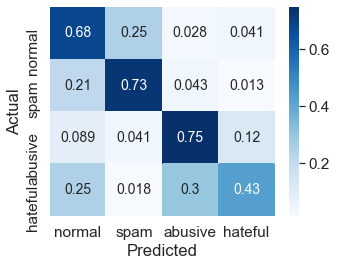

In [13]:
import seaborn as sn
cm = confusion_matrix(y, y_pred)
cm = cm/cm.sum(axis=1, keepdims=True)
df_cm = pd.DataFrame(cm, columns=['normal', 'spam', 'abusive', 'hateful'], index = ['normal', 'spam', 'abusive', 'hateful'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 14})# font size
plt.tight_layout()
plt.savefig('cm.png')

In [14]:
orig_df = pd.read_csv('/Users/sanjana/hatespeech_detection/data/hatespeech_text_label_vote_RESTRICTED_100K.csv', header=None, sep='\t')
orig_df.columns = ['text', 'label', 'votes']
orig_df.drop_duplicates(subset ="text", keep = 'first', inplace = True) 
orig_df = orig_df[orig_df['votes'] >=3]
orig_df = orig_df.reset_index(drop=True)
# df['label'] = df['label'].apply(lambda x: assign_label(x))

In [15]:
df['votes'] = orig_df['votes'].tolist()

In [16]:
ha = df[(df.y == 3) & (df.y_pred==2)].sort_values('votes', ascending=False).index.tolist()
hh = df[(df.y == 3) & (df.y_pred==3)].sort_values('votes', ascending=False).index.tolist()
ah = df[(df.y == 2) & (df.y_pred==3)].sort_values('votes', ascending=False).index.tolist()
aa = df[(df.y == 2) & (df.y_pred==2)].sort_values('votes', ascending=False).index.tolist()
hn = df[(df.y == 3) & (df.y_pred==0)].sort_values('votes', ascending=False).index.tolist()
sn = df[(df.y == 1) & (df.y_pred==0)].sort_values('votes', ascending=False).index.tolist()
ss = df[(df.y == 1) & (df.y_pred==1)].sort_values('votes', ascending=False).index.tolist()
ns = df[(df.y == 0) & (df.y_pred==1)].sort_values('votes', ascending=False).index.tolist()
nn = df[(df.y == 0) & (df.y_pred==0)].sort_values('votes', ascending=False).index.tolist()

In [17]:
data, _ = read_file('../hatespeech', with_evaluation=True)

In [19]:
# import pickle
# with open('/Users/sanjana/Text-Attention-Heatmap-Visualization/attn.pkl', 'wb') as f:
#     pickle.dump((data, df, att_weights), f)

In [37]:
max_alpha = 0.8 
for idx in ha[:1000]:
#     print(y_dist[idx])
    text = data[idx].lower()
    cleaned_text = data_joined[idx].split()
    weights = att_weights[idx][:len(cleaned_text)]
    weight_dict = {}
    for i in range(len(cleaned_text)):
        weight_dict[cleaned_text[i]] = weights[i]
    highlighted_text = []
    for i, word in enumerate(text.split()):
        if word in weight_dict:
            weight = weight_dict[word]
            highlighted_text.append('<span style="background-color:rgba(255,0,0,' + str(weight / max_alpha) + ');">' + html_escape(word) + '</span>')
        else:
            highlighted_text.append(word)
    highlighted_text = ' '.join(highlighted_text)
    display(HTML(highlighted_text))

1. require general knowledge between hateful/normal